# Course Work Neural Computation - Group 26 Source Code

## 1. Using Google colab for accessing GPU server

[Tutorial Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/uob/neural/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/drive/MyDrive/uob/neural/') #Extracts the files into the /tmp folder
zip_ref.close()

In [2]:
import os
os.listdir("/content/drive/MyDrive/uob/neural/")

['cleaned_source_code_normalisation_deactivated.ipynb',
 'data.zip',
 '__MACOSX',
 'data']

## Introduction

Image segmentation is a widely adopted machine learning (ML) technique across various fields, such as face recognition, automotive, medical imaging, content based image retrieval etc [1](https://en.wikipedia.org/wiki/Image_segmentation). This project aims to explore/solve for one such application in the field of radiology, in specific segmentation of cardiovascular magnetic resonance (CMR) imaging using a state-of-the-art (SOTA) Convolutional neural network (CNN) architecture.The raw input images with millions of pixels are transformed by grouping together distinct pixels into a more simpler image that highlights the important characteristics while retaining the same information of actual image.The number of unique pixels is greatly reduced as a result, with each pixel value reflecting a separate feature of the image.

Traditionally, image segmentation is done by manually highlighting the scans, which is tedious and prone to human errors [2](https://canvas.bham.ac.uk/courses/56310/files/11921316?wrap=1). With current computational advancements and lots of historical data of segmented images, such tasks can now be automated using Machine Learning(ML). CNN is one of the most popular ML techniques for segmentation. Current state-of-the-art (SOTA) CNN architectures used exclusively in the field of radiology include UNet, DeepLab, Mask R-CNN, Gated-SCNN [3](https://pubs.rsna.org/doi/full/10.1148/radiol.2018180547).

The data set is a modified ACDC set provided by the University of Birmingham. Due to the limited computational capacity available, the CNN architecture implemented is a simple adaptation of the popular U-Net architecture.

This CMR segmentation task requires us to classify each pixel in a given input CMR image into one of four regions/classes; the background, right ventricle (RV), the myocardium (Myo), and the left ventricle (LV). These four regions are labeled as 0,1,2 and 3 respectively. The dataset used for this task consists of 200 CMR images, mask (ground truth segmented image) pairs. 50% of the data is used for training, 10% for validation, and 40% for testing. Each input image is a greyscale image with pixel values ranging from 0 to 255. The corresponding masks consist of pixels valued between 0 and 3, each corresponding to their respective region/class label.

## 2. Exploratory Data Analysis


---



In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

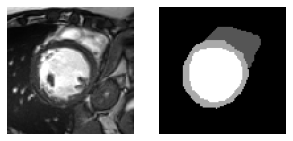

True

In [4]:
import os
import cv2
dir = '/content/drive/MyDrive/uob/neural/'
data_dir = os.path.join(dir, 'data/train')
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

In [5]:
### see the number of images in train and test

print(f"Train images: {len(os.listdir(os.path.join(dir, 'data/train/image')))}")
print(f"Validation images: {len(os.listdir(os.path.join(dir,'data/val/image')))}")
print(f"Test images: {len(os.listdir(os.path.join(dir, 'data/test/image')))}")

Train images: 100
Validation images: 20
Test images: 80


### 2.1 Image Augmentations

- Since we have only 100 training images, we will try to implement some image transformations using OpenCV and see if it's relevant to our training images

In [6]:

import numpy as np
from PIL import Image
import random
import cv2
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as transform_F
    
#source: https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def random_rotate(image, mask):
    angles = [90,180,270]
    angle = random.choice(angles)
    image = rotate_bound(image, angle)
    mask = rotate_bound(mask, angle)
    return image, mask

def random_flip(image, mask):
    direction = random.randint(0, 1)
    image = cv2.flip(image, direction)
    mask = cv2.flip(mask, direction)
    return image, mask

## source: https://medium.com/curious-manava/center-crop-and-scaling-in-opencv-using-python-279c1bb77c74
def center_crop(img, mask, dim=(64,64)):
    width, height = img.shape[1], img.shape[0]
    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    crop_mask = mask[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img, crop_mask

def gaussian_blur(image,mask):
    image = cv2.GaussianBlur(image, (5,5),0.25)
    return image,mask

def orig_size(img, mask):
#     print('resizing to original dimensions for training nn')
    img = cv2.resize(img,(96,96),interpolation= cv2.INTER_AREA)
    mask = cv2.resize(mask, (96,96), interpolation= cv2.INTER_AREA)
    return img, mask


#### Visualising Augmentation operations

In [7]:
import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/uob/neural/data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)

#### Random Rotate image (90,180,270)

image before augmentation


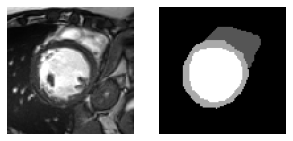

image after augmentation


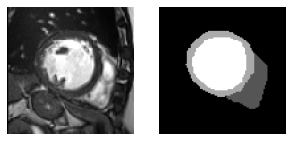

In [8]:
print("image before augmentation")
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
print("image after augmentation")
image_aug, mask_aug = random_rotate(image.copy(), mask.copy())
show_image_mask(image_aug, mask_aug, cmap='gray')

#### Random flip (horizontal and vertical)

image before augmentation


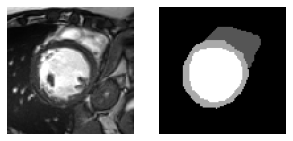

image after augmentation


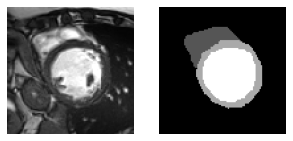

In [16]:
print("image before augmentation")
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
print("image after augmentation")
image_aug, mask_aug = random_flip(image.copy(), mask.copy())
show_image_mask(image_aug, mask_aug, cmap='gray')

#### Gaussian Blur

image before augmentation


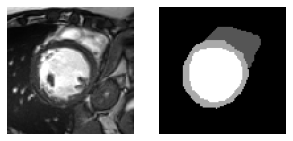

image after augmentation


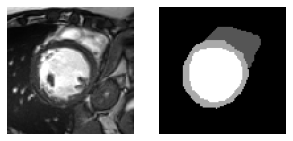

In [29]:
print("image before augmentation")
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
print("image after augmentation")
image_aug, mask_aug = gaussian_blur(image.copy(), mask.copy())
show_image_mask(image_aug, mask_aug, cmap='gray')

#### Center crop

image before augmentation


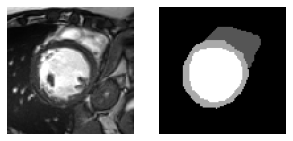

image after augmentation


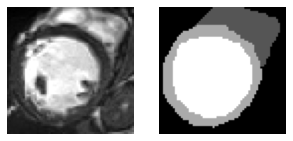

In [30]:
print("image before augmentation")
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
print("image after augmentation")
image_aug, mask_aug = center_crop(image.copy(), mask.copy())
show_image_mask(image_aug, mask_aug, cmap='gray')

- By Experimentation, we are using only flip and rotate options for image augmentation as other methods are degrading the model performance.

- Creating a single function that inputs an image and it's mask and performs these augmentations and returns the transformed image and mask

In [9]:
def get_transform(train):
    image, mask = train
    operations ={'0': random_flip, '1': random_rotate}

    ### random number of operations selected and operated on the image
    num_operations=random.randint(0,len(operations))
    selected_opertations = random.sample(operations.keys(), num_operations)
    
    for key in selected_opertations:
        image, mask = operations[key](image,mask)
    image, mask = orig_size(image, mask)
    return image, mask

### Module to create augmentations on the training data and saving to directory

In [13]:
from glob import glob
def test_augmentation(train_path, output_path, no_of_iterations=1):
    img_files = glob(os.path.join(train_path,'image','*.png'))
    mask_files = []
    for i in range(no_of_iterations):
        for img_path in img_files:
            basename = os.path.basename(img_path)
            mask_files.append(os.path.join(train_path,'mask',basename[:-4]+'_mask.png'))
        os.makedirs(os.path.join(output_path,"image"),exist_ok=True)
        os.makedirs(os.path.join(output_path,"mask"),exist_ok=True)
        k = 0
        for img,msk in zip(img_files,mask_files):
            if k%50==49:
              print(f'Completed {k} images in iteration {i}')
            data = cv2.imread(img, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(msk, cv2.IMREAD_UNCHANGED)
            try:
                data, label = get_transform([data,label])
            except Exception as e:
                print(e)
            image_name = os.path.basename(img)
            cv2.imwrite(os.path.join(output_path,"image",image_name[:-4] + f"_{i+1}.png"),data)
            cv2.imwrite(os.path.join(output_path,"mask",image_name[:-4] + f"_{i+1}_mask.png"),label)
            k += 1
test_augmentation(os.path.join(dir,'data/train'),os.path.join(dir, 'data/augment'))

Completed 49 images in iteration 0
Completed 99 images in iteration 0


#### Now merging the original training data + the augmented *images*

In [16]:
### merge training with augemented data
from glob import glob
import os

new_image= os.path.join(dir, 'data/new_train_aug','image')
print(new_image)
os.makedirs(new_image, exist_ok=True)
new_mask = os.path.join(dir, 'data/new_train_aug','mask')
os.makedirs(new_mask, exist_ok=True)

train_path = os.path.join(dir,'data/train')
augmented_path = os.path.join(dir, 'data/augment')
img_files_train = glob(os.path.join(train_path,'image','*.png'))
img_files_augmented =  glob(os.path.join(augmented_path,'image','*.png'))

mask_files_train = glob(os.path.join(train_path,'mask','*.png'))
mask_files_augmented =  glob(os.path.join(augmented_path,'mask','*.png'))

for img_path in img_files_train+img_files_augmented:
  ## ideal way would be using os.system but, this method is taking long time to run on google colab. Hence, using cv2.imwrite
  # os.system(f'''cp "{img_path}" "{os.path.join(new_image, img_path.split('/')[-1])}" ''')
  img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
  cv2.imwrite(os.path.join(new_image, img_path.split('/')[-1]), img)

for mask_path in mask_files_augmented + mask_files_train:
  # os.system(f'''cp "{mask_path}" "{os.path.join(new_mask, mask_path.split('/')[-1])}" ''')
  mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
  cv2.imwrite(os.path.join(new_mask, mask_path.split('/')[-1]), mask)


/content/drive/MyDrive/uob/neural/data/new_train_aug/image


In [17]:
len(os.listdir(new_image))

200

Now we have added 100 augemnted images along with the original train data and hence we have 200 images for the model to learn from

### 2.2 Data Normalization

Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. The distribution of such data would resemble a Gaussian curve centered at zero.

[reference](https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/)

#### Sample image
##### Original distribution

Text(0.5, 1.0, 'distribution of pixels')

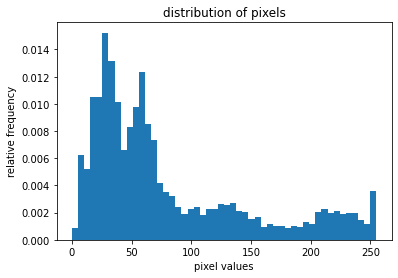

In [18]:
### Testing with a sample image

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
  
# load the image
img_path = os.path.join(dir,'data/train/image/cmr1.png')
img = Image.open(img_path)
  
# convert PIL image to numpy array
img_np = np.array(img)
  
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

#### Converting to tensor and checking the distribution

Text(0.5, 1.0, 'distribution of pixels')

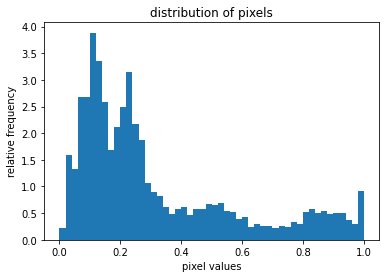

In [19]:
# import necessary libraries
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
  
# define custom transform function
transform = transforms.Compose([
    transforms.ToTensor()
])
  
# transform the pIL image to tensor 
# image
img_tr = transform(img)
  
# Convert tensor image to numpy array
img_np = np.array(img_tr)
  
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

#### Calulating the mean and std

In [20]:
# get tensor image
img_tr = transform(img)
  
# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
  
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.3152])
Std of the image: tensor([0.2636])


#### Normalising the tensor with the obtained values

Text(0.5, 1.0, 'distribution of pixels')

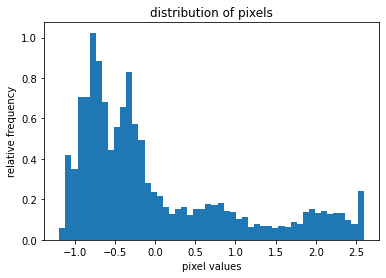

In [21]:

from torchvision import transforms
  
# define custom transform
# here we are using our calculated
# mean & std
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
  
# get normalized image
img_normalized = transform_norm(img)
  
# convert normalized image to numpy
# array
img_np = np.array(img_normalized)
  
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

#### We will calculate the average mean and std of the images and fix it for normalisation

In [23]:
from glob import glob
train_image_path = '/content/drive/MyDrive/uob/neural/data/new_train_aug/image'
total_mean, total_std = [],[]
for img_pth in glob(os.path.join(train_image_path,'*.png')):
  img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)  
  # get tensor image
  img_tr = transform(img)
    
  # calculate mean and std
  mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
  total_mean.append(mean.numpy()[0])
  total_std.append(std.numpy()[0])
avg_mean = sum(total_mean)/len(total_mean)
avg_std = sum(total_std)/len(total_std)
print(f"Average mean for the training data: {avg_mean}")
print(f"Average std for the training data: {avg_std}")

Average mean for the training data: 0.264145590364933
Average std for the training data: 0.23011214554309845


torch.Size([1, 96, 96]) <class 'torch.Tensor'>
torch.Size([1, 96, 96]) <class 'torch.Tensor'>


Text(0.5, 1.0, 'distribution of pixels')

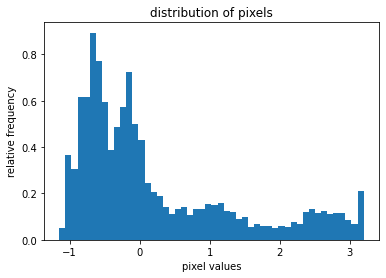

In [24]:
# load the image
img_path = os.path.join(dir,'data/train/image/cmr1.png')
img = Image.open(img_path)
  
# convert PIL image to numpy array
img_np = np.array(img)

from torchvision import transforms
  
# define custom transform
# here we are using our calculated
# mean & std
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(avg_mean, avg_std)
])
  
# get normalized image
img_normalized = transform_norm(img)
img_tensor = transform(img)
print(img_normalized.shape, type(img_normalized))
print(img_tensor.shape, type(img_tensor))
# convert normalized image to numpy
# array
img_np = np.array(img_normalized)
  
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

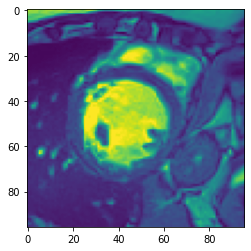

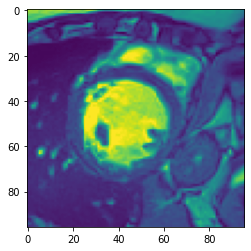

In [25]:

# Python Code to visualize normalized image
img_cp = img.copy()
# get normalized image
img_normalized = transform_norm(img)
  
# convert tis image to numpy array
img_normalized = np.array(img_normalized)
  
# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)
plt.imshow(img_cp)
plt.pause(1)
# display the normalized image
plt.imshow(img_normalized.squeeze())

In [15]:
print(img_normalized.squeeze())
print('----')
print( np.array(img_cp))

[[ 2.6695437   2.5673115   2.5161958  ...  0.8804807   0.76120985
   0.6249003 ]
 [ 2.431002    2.431002    2.4650793  ...  0.79528725  0.6589777
   0.47155204]
 [ 2.2094991   2.090228    1.9709573  ...  0.641939    0.5056294
   0.33524248]
 ...
 [-0.312228   -0.51669234 -0.27815062 ... -0.24407323 -0.19295715
  -0.3463054 ]
 [ 0.04558465 -0.12480236 -0.41446018 ... -0.29518932 -0.17591844
  -0.24407323]
 [-0.55076975 -0.49965367 -0.46557626 ... -0.24407323 -0.15887976
  -0.17591844]]
----
[[224 218 215 ... 119 112 104]
 [210 210 212 ... 114 106  95]
 [197 190 183 ... 105  97  87]
 ...
 [ 49  37  51 ...  53  56  47]
 [ 70  60  43 ...  50  57  53]
 [ 35  38  40 ...  53  58  57]]


### Checking if the normalised images have a mean ~0 and std ~1 to verify normalization

In [26]:
train_image_path = '/content/drive/MyDrive/uob/neural/data/new_train_aug/image'
total_mean, total_std = [],[]
for img_pth in glob(os.path.join(train_image_path,'*.png')):
  img = cv2.imread(img_pth, cv2.IMREAD_UNCHANGED)  
  # get tensor image
  img_tr = transform_norm(img)
    
  # calculate mean and std
  mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
  total_mean.append(mean.numpy()[0])
  total_std.append(std.numpy()[0])

avg_mean_normal = sum(total_mean)/len(total_mean)
avg_std_normal = sum(total_std)/len(total_std)

print(f"Average mean for the normalised training data: {round(avg_mean_normal, 3)}")
print(f"Average std for the normalised training data: {round(avg_std_normal, 3)}")

Average mean for the normalised training data: -0.0
Average std for the normalised training data: 1.0


Even though theroetically normalization should help to improve the model learning, in our case, it is not proving to be useful, Hence deactivating the normalisation

In [61]:
### key to activate/deactivate normalisation
tranform_data = False

### 2.2 Define a DataLoader
-  Here we are creating data loaders for training, validation and test datasets  

In [60]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

### Loading Training data (added option to transform to normalised tensors)
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index, transform = tranform_data):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            if(transform is not False):
              data, label = transform_norm(image), label
              data = data.squeeze().float()
              label = torch.from_numpy(label).float()
            else:
              data, label = torch.from_numpy(data).float(), torch.from_numpy(label).float()
              # print(f"image tensor without transform {type(data), data.shape}")
            return data, label

    def __len__(self):
        return len(self.img_files)

### Test data loader
class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index, transform = tranform_data):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if(transform is not False):
              data = transform_norm(data)
              data = data.squeeze().float()
            else:
              data = torch.from_numpy(data).float()
            return data
    def __getfilenames__(self,index):
        return self.img_files[index]
    def __len__(self):
        return len(self.img_files)

### Validation data loader
class Validationset(data.Dataset):
    def __init__(self, root=''):
        super(Validationset, self).__init__()
        self.img_files = glob(os.path.join(root, 'image', '*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root, 'mask', basename[:-4] + '_mask.png'))

    def __getitem__(self, index, transform = tranform_data):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if transform is not False:
          data = transform_norm(data)
          data, label  = data.squeeze().float(), torch.from_numpy(label).float()
        else:
          data, label = torch.from_numpy(data).float(), torch.from_numpy(label).float()

        return data, label

    def __len__(self):
        return len(self.img_files)

### 2.3 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

We will be scoring the NN after each iteration with the cross entropy loss and the Dice Score.

In [28]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 2.2 Define a Segmenatation Model

We will be using the U-Net architecture to create our network. This network will contain an encoder part where we learn the features of the image and after that we will upsample the features with a decoder to learn the pixelwise mapping to create the segmentation output

A typical CNN framework consists of three components; the architecture, loss function, and the optimizer. This framework is used for training and validation along with hyperparameter tuning to get the best possible accuracy. a hyperparameter is a parameter that controls the training process and affects the training efficiency significantly. The number of epochs, the training batch size, and the optimizer's learning rate is the hyperparameters in this project.

The architecture used is inspired from [4](https://arxiv.org/abs/1505.04597), a simple adaptation of the original U-Net. Three different architectures were created with varying depths. "UNET_shallow" is the shallow architecture that is 4 layers deep, with the fourth layer being the bottom part of the shape "U", Followed by another 4 layers in the upward "U" direction with the 4th layer being the output layer. "UNET_moderate" follows the same "U" shape but with a depth of 5 layers and 5 layers up. Finally, the "UNET_deep" is the deepest model being 6 layers on each side. 


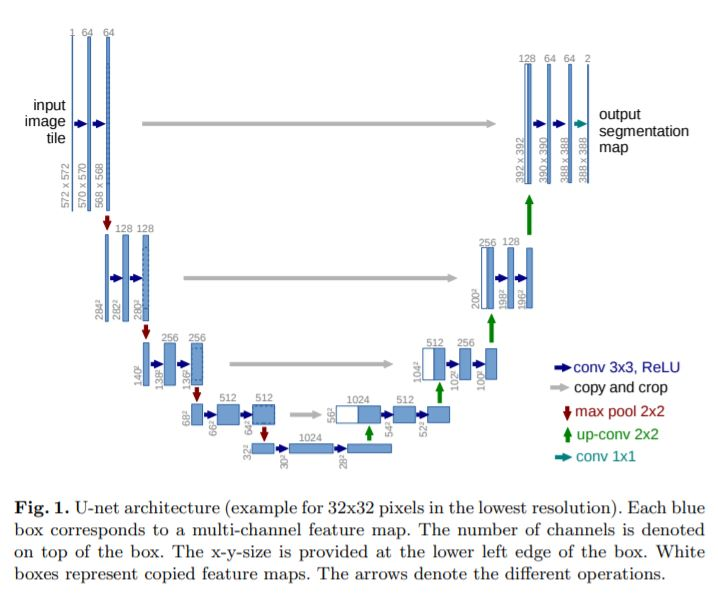

In [1]:
from IPython.display import Image
Image(filename='UNet.jpg')

On the way down the "U" shape, the model performs two consecutive convolutions with a 3x3 kernel matrix followed by a ReLU activation function. However, it should be noted that the model has a padding parameter set to 1 for each convolution. This makes sure that after each convolution, the image size remains the same. The image is then sent through a 2x2 max pool, which reduces the image size by half. 
In essence, the input images are downsampled as they move down the "U" shape.

At the bottom of the "U" shape, the image again undergoes two consecutive 3x3 convolutions and is ready to be upsampled. The upsampling is done by increasing the image size by a factor of two. This is achieved using a 3x3 transpose convolution. However, to achieve the desired upsampling, the padding parameter was set to 1. But, this still doesn't guarantee an upsampling by a factor of two. This is because multiple images with different sizes can convolve into an image of identical dimensions. Therefore performing transpose convolution of this image is vague, as it can revert to any of the original images with varying dimensions. This gives rise to the need for another parameter to break this vagueness and revert to the desired image dimension. This is called as output padding parameter, set to 1 in our case to get the desired upsampling result. After upsampling, the image again goes through two 3x3 convolutions with a padding of 1 (to maintain image size). This process is continued until the image dimensions reach the original input dimension.

The discussed architecture is applied for our current problem, A single channel 96x96 image is fed into the network. The output channels, shown in the code are increased by a power of 2 at each layer starting with 16. This was chosen as a large number of successful models always consisted of channels number in the power of 2s. The image size is downscaled to various sizes depending on the network level, ranging from 12x12 in the shallow network to 3x3 in the deep network. Followed by, Transconvolution which is used to accomplish a steady upsampling, and the final output is a 96x96 image with four channels (one for each class label). The choice of kernel size is strictly based on the original U_NET paper which used the same dimensions.

In addition, in line with traditional U-NET architecture, skip connections are also implemented. This allowed features maps (channels) that are created during convolution while downsampling to be directly concatenated to the convolution performed in the upsampling step.The feature maps of a downsampling layer at a certain depth are only concatenated on the upsampling layer at the same depth, as demonstrated in the diagrams and supporting code. Skip connection is essential as it prevents the loss of information about the original image. Skip connections directly pass on the information about the image to layers at the same depth. On the contrary, without skip connections, information about the original image is lost while downsampling and the subsequent upsampling doesn't generate any new useful information. 

Below is the associated code for the UNet Architecture

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

class UNET_test(nn.Module):  # Define your model
    def __init__(self):
        super(UNET_test, self).__init__()
        # steady downsampling
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)

        # bottom part of the "U" shape
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)

        # steady upsampling
        self.tranconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv9 = nn.Conv2d(128 * 2, 128, 3,
                               padding=1)  # need to be skip connected so the input channels are mutiplied by 2 (check diagram)
        self.conv10 = nn.Conv2d(128, 128, 3, padding=1)

        self.tranconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv11 = nn.Conv2d(64 * 2, 64, 3,
                                padding=1)  # need to be skip connected so the input channels are mutiplied by 2 (check diagram)
        self.conv12 = nn.Conv2d(64, 64, 3, padding=1)

        self.tranconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv13 = nn.Conv2d(32 * 2, 32, 3,
                                padding=1)  # need to be skip connected so the input channels are mutiplied by 2 (check diagram)
        self.conv14 = nn.Conv2d(32, 4, 3, padding=1)

    def forward(self, x):
        skips = []
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        skips.append(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        skips.append(x)
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        skips.append(x)
        x = self.pool(x)

        skip_reverse = skips[::-1]

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = torch.cat([skip_reverse[0], self.tranconv1(x)], 1)

        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = torch.cat([skip_reverse[1], self.tranconv2(x)], 1)

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = torch.cat([skip_reverse[2], self.tranconv3(x)], 1)

        x = self.conv13(x)
        x = self.conv14(x)
        return x
model = UNET_test().to(device)

The current device is cuda:0


### 2.3 Define a Loss function and optimizer

We will be using the cross entropy loss for loss function and Adam Optimiser for Optimising. After extensive investigation [5](https://arxiv.org/pdf/2007.02839.pdf), [6](https://www.researchgate.net/publication/342672752_State-of-the-Art_CNN_Optimizer_for_Brain_Tumor_Segmentation_in_Magnetic_Resonance_Images), it was discovered that adam is the best optimizer for the current work, owing to the typically speedy convergence for CNN tasks. The loss function is pixel-wise crossentropy after an extensive study into loss functions for segments revealed that cross entropy loss is the most dependable [7](https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/). The fact is that there is a tremendous class imbalance in the ground truth. Consider the image "mask 1.png," which has 6663 pixels classified as 0, 557 pixels classified as 1, 671 pixels classified as 2, and 1325 pixels classified as 3.This indicates that a given pixel from an image has a high chance of being in class 0, but it is not in fact in class 0. The background pixels, i.e. black pixels (class 0), are the source of this imbalance. This is prevented by giving class 0 less significance compared to other classes (Class 1,2 and 3). The exact weights were calculated by calculating the average pixels per class across the training and validation set along with the reciprocal of the respective proportions (total pixel count is 96x96). This gave a set of weights 1.3, 20, 16.5, 16.5 respectively. The next step is to perform a brief analysis of the three models introduced above (deep, moderate and shallow). The best performing model will be taken up for further tuning. All techniques used for training and validation is avaliable in the source code itself.



In [30]:
import torch.optim as optim
class_weight = torch.tensor([1.3,20,16.5,16.5])
loss = nn.CrossEntropyLoss(weight = class_weight)
# if device!='cpu':
loss = loss.to(device)
optimiser = optim.Adam(model.parameters(), lr = 0.001)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [57]:
from torch.utils.data import DataLoader
### Invoking train and validation Data loaders
data_path = os.path.join(dir,'data/new_train_aug')
num_workers = 0
batch_size = 1
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
validation_set = Validationset(os.path.join(dir,"data/val/"))
validation_data_loader = DataLoader(dataset=validation_set, num_workers=0, batch_size=1, shuffle=True)

### Creating lists to record the dice and cross entropy loss
train_loss_epoch = []
test_loss_epoch = []
train_dice_epoch = []
test_dice_epoch = []

for epoch in range(150):  # loop over the dataset multiple times
    train_loss = []
    train_dice_loss = []
    test_loss = []
    test_dice_loss = []
    model.train()
    for i, sample in enumerate(training_data_loader):
        img, mask = sample
        img = img.unsqueeze(1)
        mask = mask.type(torch.long)
        ### loaded tensors to cpu/gpu
        img, mask = img.to(device), mask.to(device)

        optimiser.zero_grad()
        ### forward + loss calculations
        output = model(img)
        lloss = loss(output, mask)/batch_size
        new_image = np.argmax(output[0].detach().cpu().numpy(),axis=0)
        dice_score=sum([categorical_dice(mask[0,:].squeeze().detach().cpu().numpy(),new_image,x) for x in [0, 1, 2, 3]])/4
        train_dice_loss.append(1-dice_score)
        if i%100==99:
            # show_image_mask(mask[0,...].detach().cpu().squeeze(),new_image)
            print(f"\titeration: {i} epoch: {epoch+1} loss: {lloss.item()}, dice score:{dice_score}")
        ### backward + optimize
        lloss.backward()
        optimiser.step()
        train_loss.append(lloss.item())
    
    ### Calulating average training loss after each epoch
    avg_cross_loss = sum(train_loss) / len(train_loss)
    avg_dice_loss = sum(train_dice_loss) / len(train_dice_loss)
    train_dice_epoch.append(avg_dice_loss)
    train_loss_epoch.append(avg_cross_loss)
    print(f"Training : epoch: {epoch}, running_loss: {avg_cross_loss}, dice_loss: {avg_dice_loss}")
    
    ### evaluating current model on the validation dataset
    with torch.no_grad():
        for i, sample in enumerate(validation_data_loader):
            img, mask = sample
            # print(img.shape)
            img = img.unsqueeze(1)
            mask = mask.type(torch.long)
            img = img.to(device)
            mask = mask.to(device)
            ### model switching to eval mode
            model.eval()
            ### prediction
            output = model(img)
            new_image=np.argmax(output[0].detach().cpu().numpy(),axis=0)
            ### calulating loss
            dice_score=sum([categorical_dice(mask[0,:].squeeze().detach().cpu().numpy(),new_image,x) for x in [0, 1, 2, 3]])/4
            lloss = loss(output, mask).item()
            if i % 100 == 99 :
              print(f"\titeration: {i+1} dice_loss: {1-dice_score}, crs_entrpy_loss: {lloss}")
            test_loss.append(lloss)
            test_dice_loss.append(1-dice_score)
    ### Calculating average validation loss after each epoch
    avg_cross_loss = sum(test_loss) / len(test_loss)
    avg_dice_loss = sum(test_dice_loss) / len(test_dice_loss)
    test_dice_epoch.append(avg_dice_loss)
    test_loss_epoch.append(avg_cross_loss)
    print(f"Validation : epoch: {epoch}, running_loss: {avg_cross_loss}, dice_loss: {avg_dice_loss}")
    
    ### Saving the model for every 50 iterations
    if epoch%30==0:
        torch.save(model.state_dict(),os.path.join(dir,f'./unet_{epoch}.pt'))

print('Finished Training')


	iteration: 99 epoch: 1 dice score:0.44905220848791005, loss: 1.1371222734451294
	iteration: 199 epoch: 1 dice score:0.5148354854052888, loss: 1.0642653703689575
Training : epoch: 0, running_loss: 4.241203803420067, dice_loss: 0.6482771990847098
Validation : epoch: 0, running_loss: 1.213164734840393, dice_loss: 0.676175542780391
	iteration: 99 epoch: 2 dice score:0.345710244882142, loss: 1.0683128833770752
	iteration: 199 epoch: 2 dice score:0.39677576854762353, loss: 1.2711119651794434
Training : epoch: 1, running_loss: 1.086800327897072, dice_loss: 0.5911679561551534
Validation : epoch: 1, running_loss: 1.1831148326396943, dice_loss: 0.6557610175858551
	iteration: 99 epoch: 3 dice score:0.4073150773248595, loss: 1.0175572633743286
	iteration: 199 epoch: 3 dice score:0.48232006196943145, loss: 0.8906057476997375
Training : epoch: 2, running_loss: 1.0757369464635849, dice_loss: 0.5803605322714712
Validation : epoch: 2, running_loss: 1.2170297145843505, dice_loss: 0.6236501910445045
	it

KeyboardInterrupt: ignored

In [50]:
### saving final model
torch.save(model.state_dict(),os.path.join(dir,'unet_final.pt'))

#### Plotting Average Dice and Cross entropy loss against epochs

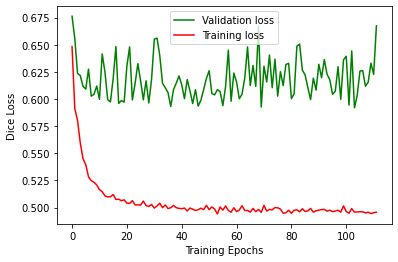

In [58]:
plt.plot(range(len(test_dice_epoch)), test_dice_epoch,'g', label="Validation loss")
plt.plot(range(len(train_dice_epoch)), train_dice_epoch,'r', label="Training loss")
plt.xlabel("Training Epochs")
plt.ylabel("Dice Loss")
plt.legend()
plt.show()

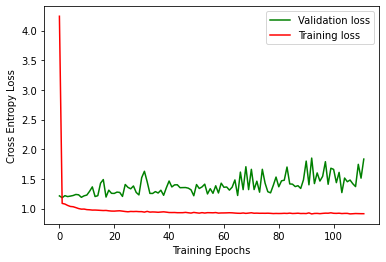

In [59]:
plt.plot(range(len(test_loss_epoch)), test_loss_epoch,'g', label="Validation loss")
plt.plot(range(len(train_loss_epoch)), train_loss_epoch,'r', label="Training loss")
plt.xlabel("Training Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

### Experiment

The project begins by analysing the three models introduced in the first section These are the shallow, moderate and deep models. The goal here is to see which model gives the best performance for given values of epoch, learning rate (LR) and batch size. Due to time constraints and limited computational power, an epoch of 60 was set. The learning rate was chosen as 0.001 which is the default value provided by the Adam class in PyTorch. The batch size was set to 4. This was to ensure we don’t overfit or underfit the model as large batch sizes can lead to a more general and inaccurate models and lower batch size can lead to overfitting and a long time to converge to a low loss value. A batch size of 4 was the sweet spot for this purpose. 

After training on the augmented set of 300 images, it was clear that “UNet_moderate” gave the best overall performance. The shallow and the moderate model converged to a low dice and cross entropy loss value before the 60 epoch mark, with the moderate model converging quicker. Both showed best performance at the 50th epoch mark associated with the lowest dice and cross entropy loss value. However, the cross entropy and the dice scores for the validation set is significantly lower for the moderate model compared to the shallow model at the 50th epoch mark. This can be attributed to the lower number of parameters associated with the shallow model and therefore this model lacked ability to learn more subtle features. Both showed overfitting tendency at the 60th epoch mark. The deep model performed the worst out of all three. This can be attributed to the large number of parameters it had to learn within 60 epochs. This negatively impacted the model to converge quickly and efficiently. Therefore out of the three, the moderate model performs the best and can be taken for hyper parameter tuning. This model is the best of both worlds i.e, it has enough number of parameters to learn the subtle features of input images without overfitting or underfitting.

Given that our moderate model converged and started to overfit around the 60 epoch mark, it is clear that this model performs best in the 45-55 epoch region. Due to this we do not need to tune the number of epochs and will set it as 60. The parameters left to tune are the learning rate for the optimiser and the batch size. It was decided to experiment on the batch size first by setting values higher than 4. It was decided not to experiment on values lower than 4 due to the long convergence time. Setting batch size 6. Clearly the plot shows in overall improvement in the dice and cross entropy scores. The dice score for the validation is around the same region as we saw for batch size 4. The cross entropy loss is higher for batch size 6 which is a strong indication to not pursue this model parameter. It was now suspected that increasing batch size would not lead to any improvement in the model performance due to the loss of ability of the model to pick more subtle features. This is because the model will always try to reduce the batch loss which can be done by setting parameters that is as general as possible such that even though the model would not accurately segment individual images, it will output a generalised segmentation such that as a group the overall loss is reduced. This is not beneficial for us due to the need to capture the subtlety in the input images. This conviction was strengthened by testing with batch size 10. Clearly the model performed very similar to the batch size 6 case with no significant improvement over batch size 4. This indicated that 4 was the ideal batch size for our model. Next parameter the project experimented was the learning rate. Countless experiments were done with high and low values of LR and the best value obtained was 0.0008. Anything higher than 0.001 usually took longer than 60 epochs to converge and values lower than 0.0008 usually stagnates and very frequently overfits the data.

Therefore, an epoch of 60, learning rate of 0.0008 and batch size of 4 was found to be the best set of hyperparameters. However, on checking some of the validation masks, it was noted that the model, on some occasions, did not accurately segment classes 2 and 3. Due to this, the cross entropy weights for these classes were increased by one unit. The new weights were set to [1.3,20,17.5,17.5]. This gave an improvement of 1% in the validation dice score to an average dice score of 85%. Note that this value only accounted for correct classification of classes 1,2 and 3 and discounted the background. This model was obtained at the 50th epoch mark.

Therefore, through this brief qualitative analysis, an optimal set of hyperparameters were selected and the corresponding model was trained. This model gave an dice accuracy of 91% on the train set and 85% on the validation set. This slight discrepancy is not significant enough to indicate overfitting. 

### 2.5 Validation


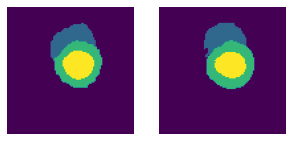

0 0.9063934975699682


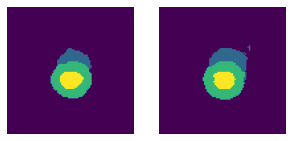

1 0.8737371035727555


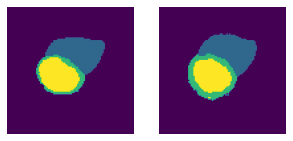

2 0.8437318871298918


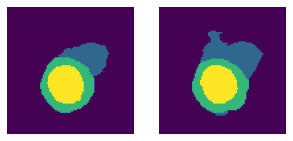

3 0.8723197050226136


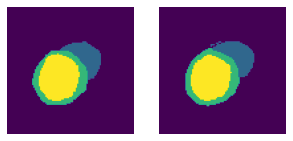

4 0.9258067334353907


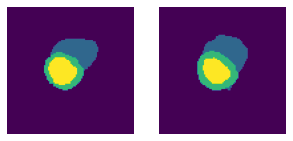

5 0.8539324534820739


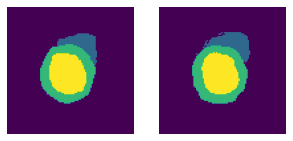

6 0.9211794775326694


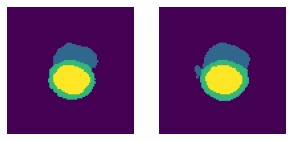

7 0.9251112152038191


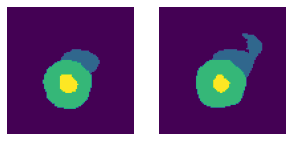

8 0.8279645779294967


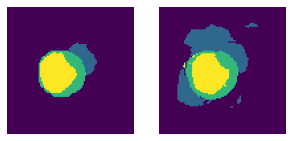

9 0.6853610937796965


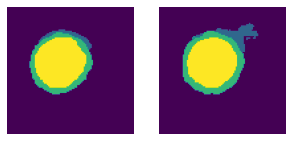

10 0.762210375567705


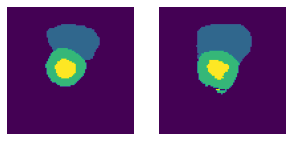

11 0.8839117348826018


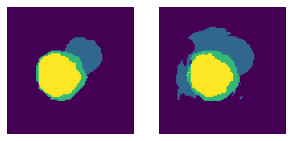

12 0.7813514974660754


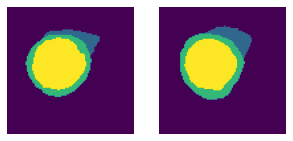

13 0.8477581407930543


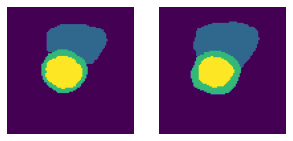

14 0.8816316454387761


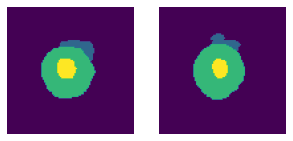

15 0.7700558661460387


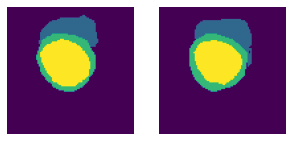

16 0.8609775450451734


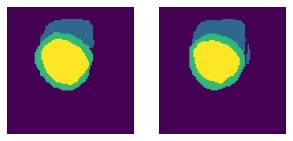

17 0.9051555407015032


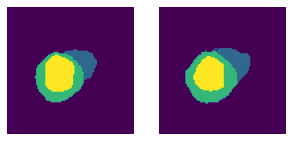

18 0.8774016016071026


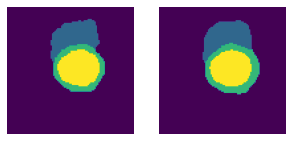

19 0.9195871479474574
Average dice loss obtained on the validation data: 0.856


In [46]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

### Loading the final model
final_model = UNET_test().to(device)
final_model.load_state_dict(torch.load(os.path.join(dir, "unet_60.pt")))

validation_set = Validationset(os.path.join(dir,'data/val/'))
prediction_folder=os.path.join(dir, 'data/val/preds')
os.makedirs(prediction_folder,exist_ok=True)

dice_scores=[]
### Predicting and calculating dice_score for the validation images against the ground truth
validation_data_loader = DataLoader(dataset=validation_set, num_workers=0, batch_size=1, shuffle=True)
for i, sample in enumerate(validation_data_loader):
    img, mask = sample
    img = img.unsqueeze(1)
    mask = mask.type(torch.long)
    img, mask = img.to(device), mask.to(device)
    output = final_model(img)
    new_image=np.argmax(output[0].detach().cpu().numpy(),axis=0)
    cv2.imwrite(os.path.join(prediction_folder,f"{i+1}.jpg"),new_image)
    show_image_mask(mask[0,...].squeeze().detach().cpu(),new_image)
    dice_score=sum([categorical_dice(mask[0,:].squeeze().detach().cpu().numpy(),new_image,x) for x in [1,2,3]])/3
    print(i,dice_score)
    dice_scores.append(dice_score)
    lloss = loss(output, mask).item()

print(f"Average dice loss obtained on the validation data: {round(sum(dice_scores)/len(dice_scores),3)}")
     

### 2.6 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [47]:
import numpy as np
from torch.autograd import Variable

In [48]:
### Calling the final model and predicting for all test images
data_path = os.path.join(dir,'/data/test')
num_workers = 0
batch_size = 1

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
final_model = UNET_test()
final_model.load_state_dict(torch.load(os.path.join(dir, "unet_60.pt")))

out_path=os.path.join(dir,'data/test/mask')
for iteration, sample in enumerate(test_data_loader):
    fpath=test_set.__getfilenames__(iteration)
    fname=fpath.split('/')[-1]
    print(iteration, fname)
    img = sample
    img = img.unsqueeze(1)
    output = final_model(img)
    new_image=np.argmax(output[0].detach().numpy(),axis=0)
    cv2.imwrite(os.path.join(out_path,fname),new_image)
    

## 3 Evaluation

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [43]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '_mask1,' + encoded_mask1 + "\n")
        writer.write(name + '_mask2,' + encoded_mask2 + "\n")
        writer.write(name + '_mask3,' + encoded_mask3 + "\n")

    writer.close()

In [34]:
submission_converter(out_path,dir)

In [35]:
import pandas as pd
df=pd.read_csv(os.path.join(dir,'submission.csv'))
df.head()

,id,encoding
0,cmr167_mask1,2352 3 2450 2 2547 2 2645 1 2777 1 2779 1 2837...
1,cmr167_mask2,2342 10 2434 16 2527 20 2622 23 2716 10 2735 7...
2,cmr167_mask3,2726 9 2817 15 2911 19 3005 22 3101 23 3196 25...
3,cmr198_mask1,2543 4 2643 2 3008 1 3102 2 3192 8 3285 11 337...
4,cmr198_mask2,2537 4 2630 13 2725 17 2820 19 2914 23 3009 25...


### Inference

The project now used the trained model to test the Kaggle test set. The score obtained was 83.1 which is very reasonable and is very close to our validation score. This indicates that our model performs fairly well on unseen data without the worry of overfitting or underfitting. 

As future work, this model can be enhanced even further by incorporating more cutting edge CNN architectures. A deeper model with more number of parameters can be used. However, this will be at a cost of high computational power and much longer convergence times. More training data can be provided for a more robust model. 

### Conclusion

In summary, this project attempted a simple image segmentation task using CNN. The model used was an intermediate between a shallow and deep model. Epoch, batch size and LR were tuned. The tuned model have an average dice score of 83.1% on the Kaggle dataset

### References

1.  [https://en.wikipedia.org/wiki/Image_segmentation]
2. [https://canvas.bham.ac.uk/courses/56310/files/11921316?wrap=1]
3. [https://pubs.rsna.org/doi/full/10.1148/radiol.2018180547]
4. [https://arxiv.org/abs/1505.04597]
5. [https://arxiv.org/pdf/2007.02839.pdf]
6. [https://www.researchgate.net/publication/342672752_State-of-the-Art_CNN_Optimizer_for_Brain_Tumor_Segmentation_in_Magnetic_Resonance_Images]
7. [https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/]